# Comparison of real HPL executions

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

old_execution = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
new_execution = [
    '../hpl/grenoble_2019-03-15_1855885.zip'
]
dfold = pandas.concat([read_result(f) for f in old_execution])
dfnew = pandas.concat([read_result(f) for f in new_execution])
dfold['mode'] = 'old'
dfnew['mode'] = 'new'
df = pandas.concat([dfold, dfnew])
sizes = set(dfold.matrix_size) & set(dfnew.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,bcast,block_size,depth,gflops,matrix_size,mem_align,mode,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
0,2,128,1,17540.0,75000,8,old,1,32,32,32,0.000928,2,0,1,16.03
1,2,128,1,23290.0,225000,8,old,1,32,32,32,0.000612,2,0,1,326.05
2,2,128,1,22260.0,175000,8,old,1,32,32,32,0.000827,2,0,1,160.53
3,2,128,1,20990.0,125000,8,old,1,32,32,32,0.000793,2,0,1,62.02
4,2,128,1,23630.0,250000,8,old,1,32,32,32,0.000563,2,0,1,440.78


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,mem_align,rfact,process_per_node,proc_p,proc_q,bcast,thread_per_process,pfact,depth,block_size,swap
0,8,2,32,32,32,2,1,1,1,128,0


### Comparing the executions

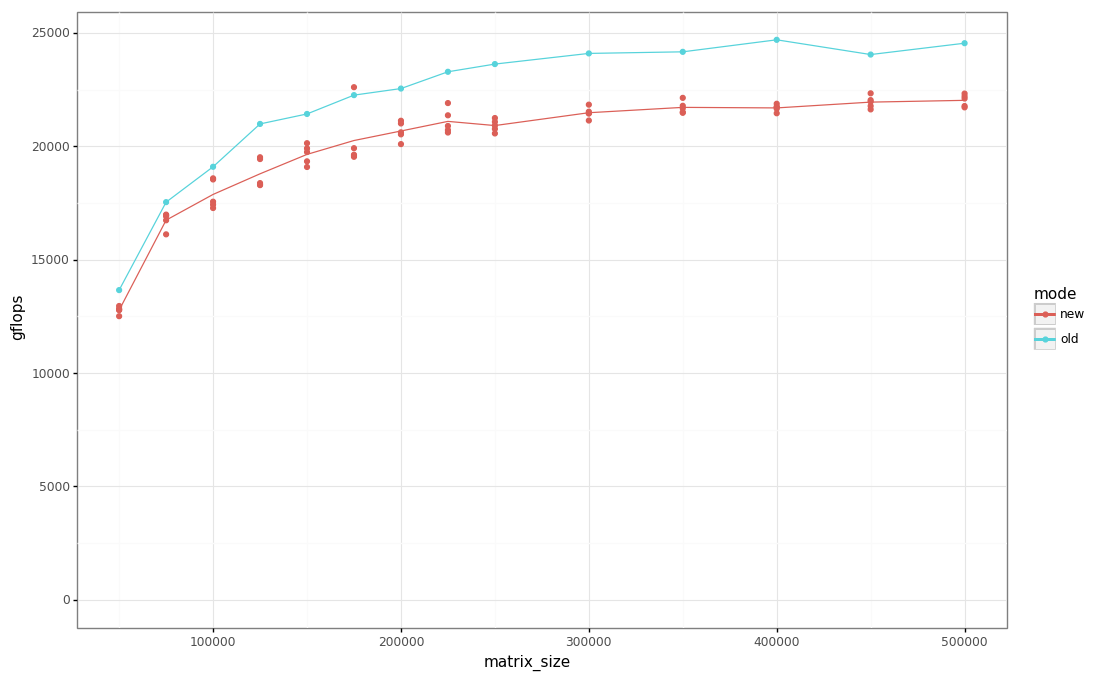

<ggplot: (8747791409479)>

In [3]:
import numpy

ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

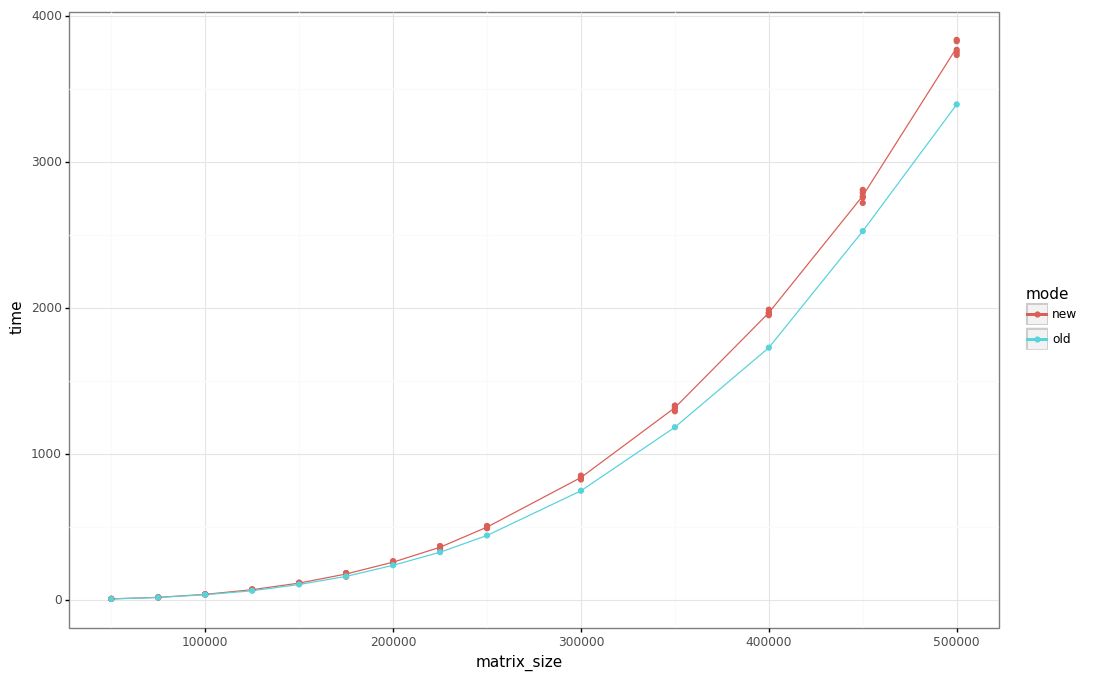

<ggplot: (-9223363289067134418)>

In [4]:
ggplot(df, aes(x='matrix_size', y='time', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

### Maximum performance

In [5]:
dfold[dfold.gflops == dfold.gflops.max()]

,bcast,block_size,depth,gflops,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time,mode
2,2,128,1,24700.0,400000,8,1,32,32,32,0.000531,2,0,1,1727.64,old


In [6]:
dfnew[dfnew.gflops == dfnew.gflops.max()]

,mem_align,process_per_node,time,block_size,matrix_size,residual,gflops,proc_q,pfact,rfact,depth,swap,thread_per_process,proc_p,bcast,mode
0,8,32,158.0,128,175000,0.000827,22610.0,32,1,2,1,0,1,32,2,new


### Regression

In [7]:
import statsmodels.formula.api as st

for df in [dfold, dfnew]:
    df['N3'] = df['matrix_size'] ** 3
    df['N2'] = df['matrix_size'] ** 2
    reg = st.ols(data=df, formula='time ~ N3+N2').fit()
    p = reg.params
    df['pred_time'] = p.Intercept + df.N2*p.N2 + df.N3*p.N3
    df['nb_flops'] = (2/3*df.N3 + 2*df.N2) * 1e-9
    df['pred_gflops'] = df['nb_flops'] / df['pred_time']
    c = reg.conf_int()
    df['pred_time_min'] = c[0].Intercept + df.N2*c[0].N2 + df.N3*c[0].N3
    df['pred_time_max'] = c[1].Intercept + df.N2*c[1].N2 + df.N3*c[1].N3
    df['pred_gflops_min'] = df['nb_flops'] / df['pred_time_max']
    df['pred_gflops_max'] = df['nb_flops'] / df['pred_time_min']

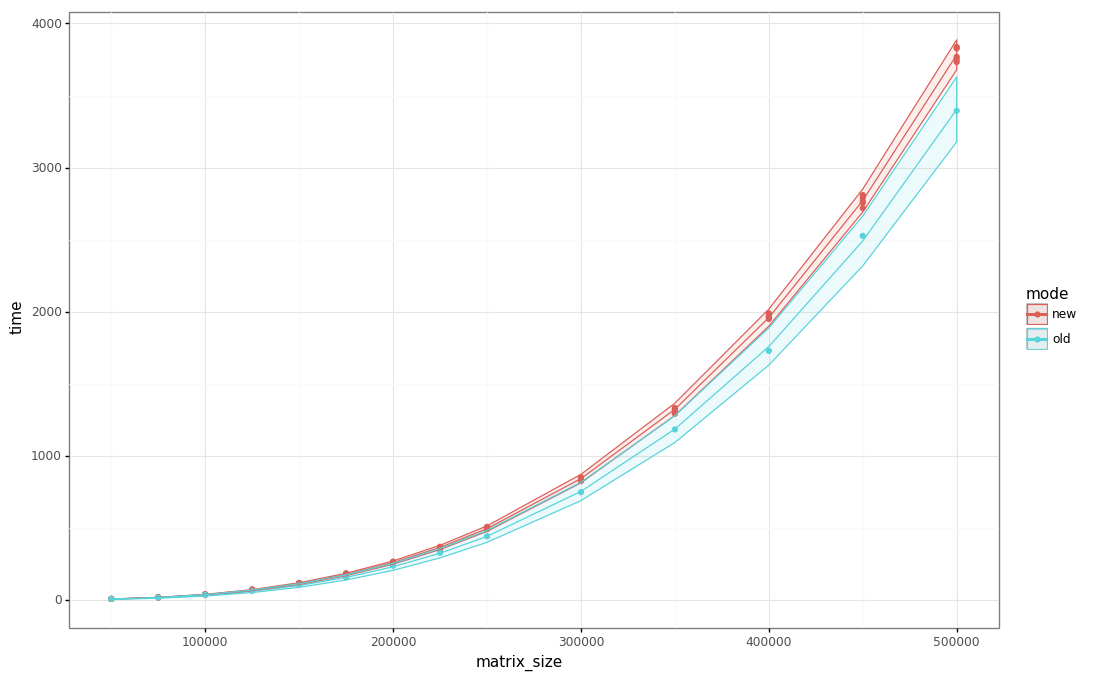

<ggplot: (-9223363289067127727)>

In [8]:
df = pandas.concat([dfold, dfnew])
plot = ggplot(df, aes(x='matrix_size', y='time', color='mode')) + geom_line(aes(x='matrix_size', y='pred_time')) + geom_point() + theme_bw() + expand_limits(y=0)
plot + geom_ribbon(aes(ymin='pred_time_min', ymax='pred_time_max', fill='mode'), alpha=0.1)

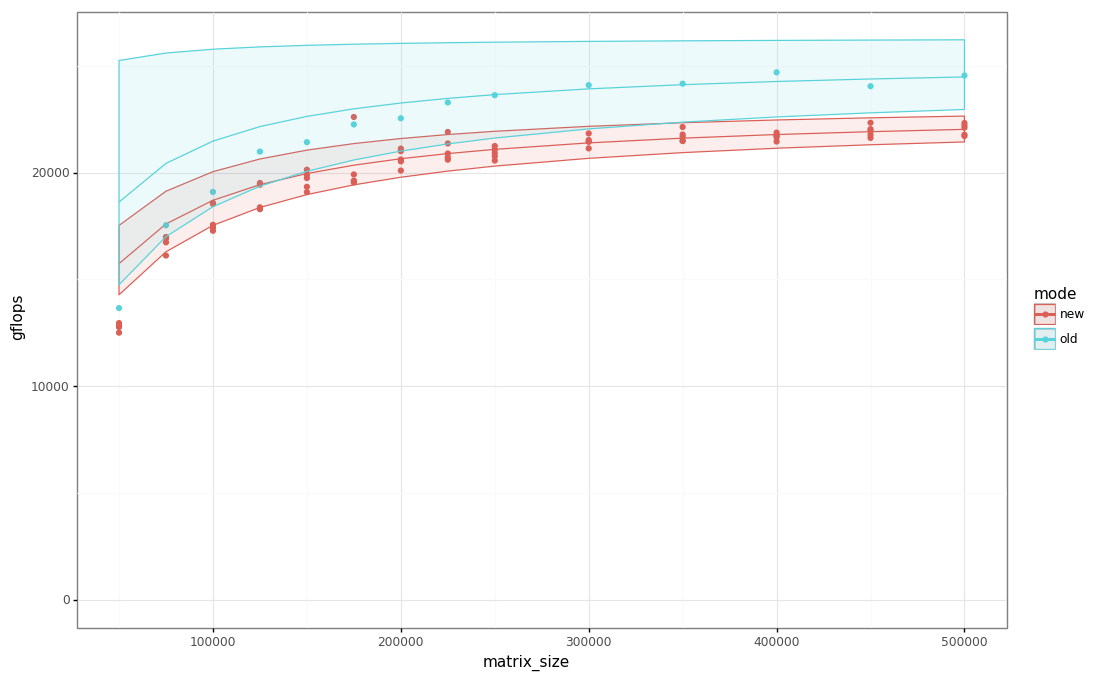

<ggplot: (-9223363289067214490)>

In [9]:
plot = ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + geom_line(aes(x='matrix_size', y='pred_gflops')) + geom_point() + theme_bw() + expand_limits(y=0)
plot + geom_ribbon(aes(ymin='pred_gflops_min', ymax='pred_gflops_max', fill='mode'), alpha=0.1)